This notebook is part of the below youtube Deep Learning with Pytorch : From Zero to GNN Series.

Deep Learning with Pytorch Youtube series: https://www.youtube.com/playlist?list=PLOrU905yPYXJsJSHJsiE779KfcrRCgz4v

#### Data Preprocessing 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os , string
# we will be using pytorch to build the model , hence importing required torch essentials
import torch
from torch.utils.data import DataLoader , TensorDataset
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Dataset Details:

Dataset contains English sentences and corresponding Korean sentences. 

Our Machine translation model will take the english sentence and will translate the same to Koren sentence. 

We have train/test dataset. 

In [2]:
# file paths
eng_train = '/kaggle/input/englishkorean-multitarget-ted-talks-task-mttt/multitarget-ted/en-ko/raw/ted_train_en-ko.raw.en'
ko_train = '/kaggle/input/englishkorean-multitarget-ted-talks-task-mttt/multitarget-ted/en-ko/raw/ted_train_en-ko.raw.ko'

eng_test = '/kaggle/input/englishkorean-multitarget-ted-talks-task-mttt/multitarget-ted/en-ko/raw/ted_test1_en-ko.raw.en'
ko_test = '/kaggle/input/englishkorean-multitarget-ted-talks-task-mttt/multitarget-ted/en-ko/raw/ted_test1_en-ko.raw.ko'

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.readlines()
    file.close()
    return text

In [4]:
# reading the files
df_eng_train = read_text(eng_train)
df_ko_train = read_text(ko_train)

df_eng_test = read_text(eng_test)
df_ko_test = read_text(ko_test)

In [5]:
# looking at the length of the different datasets

len(df_eng_train) , len(df_ko_train) , len(df_eng_test) , len(df_ko_test)

(166215, 166215, 1982, 1982)

### Data Preprocessing

1. Remove punctuation
2. To lower case
3. Remove new line charecters
4. Split into indivisual words
5. Build vocabulary of English and Korean Language 
     - index2word
     - word2index
6. Encoding and Padding each sentences from both language
7. Prepare train/test batches of data 

In [6]:
# Remove punctuation
df_eng_train = [s.translate(str.maketrans('', '', string.punctuation)) for s in df_eng_train]
df_ko_train = [s.translate(str.maketrans('', '', string.punctuation)) for s in df_ko_train]
df_eng_test = [s.translate(str.maketrans('', '', string.punctuation)) for s in df_eng_test]
df_ko_test = [s.translate(str.maketrans('', '', string.punctuation)) for s in df_ko_test]

In [7]:
# looking at one of the sentence
df_eng_train[1]

'And were going to tell you some stories from the sea here in video \n'

In [8]:
# looking into 5 pair of sentence from both the languages

for i in range(5):
    print("English: {} \n Koren: {} \n".format(df_eng_train[i].strip(), df_ko_train[i].strip()))

English: Applause David Gallo This is Bill Lange Im Dave Gallo 
 Koren: 박수 이쪽은 Bill Lange 이고 저는 David Gallo입니다 

English: And were going to tell you some stories from the sea here in video 
 Koren: 우리는 여러분에게 바닷속 이야기를 영상과 함께 들려주고자 합니다 

English: Weve got some of the most incredible video of Titanic thats ever been seen and were not going to show you any of it 
 Koren: 저희는 끝내주는 타이타닉 비디오도 있긴 합니다만 뭐여기서는 눈꼽만큼도 보여줄 생각이없습니다 

English: Laughter The truth of the matter is that the Titanic  even though its breaking all sorts of box office records  its not the most exciting story from the sea 
 Koren: 웃음 비록 타이타닉이 박스오피스에서 굉장한 실적을 거두긴 했지만 바다가 들려주는 이야기 중 가장 재밌는 것은 아닙니다 

English: And the problem I think is that we take the ocean for granted 
 Koren: 문제라면 우리는 우리가 바다를 이미 알고있다고 믿는거죠 



In [9]:
# to lower the words and remove new lines charecters
for i in range(len(df_eng_train)):
    df_eng_train[i] = df_eng_train[i].lower().rstrip("\n").split()
    df_ko_train[i] = df_ko_train[i].lower().rstrip("\n").split()
    
for i in range(len(df_eng_test)):
    df_eng_test[i] = df_eng_test[i].lower().rstrip("\n").split()
    df_ko_test[i] = df_ko_test[i].lower().rstrip("\n").split()

In [10]:
# looking at one of the sentence after the inital preprocess
df_eng_train[1]

['and',
 'were',
 'going',
 'to',
 'tell',
 'you',
 'some',
 'stories',
 'from',
 'the',
 'sea',
 'here',
 'in',
 'video']

In [11]:
# bulding the vocabulary for English and Korean Language
# first we will build the index 2 word mapping


en_index2word = ["<PAD>", "<SOS>", "<EOS>"] # <PAD> will be the zero'th index
ko_index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [df_eng_train , df_eng_test]:
    for sentence in ds:
        for token in sentence:
            if token not in en_index2word:
                en_index2word.append(token)

print('English index to word done')                
                
for ds in [df_ko_train , df_ko_test]:
    for sentence in ds:
        for token in sentence:
            if token not in ko_index2word:
                ko_index2word.append(token)

print('Koren index to word done')

English index to word done
Koren index to word done


In [12]:
# # dumping into pickle files for future use
from pickle import dump

dump(en_index2word, open('en_index2word.pkl', 'wb'))
dump(ko_index2word, open('ko_index2word.pkl', 'wb'))

In [13]:
from pickle import load

#en_index2word = load(open('../input/nlpasgn/en_index2word.pkl', 'rb'))
#ko_index2word = load(open('../input/nlpasgn/ko_index2word.pkl', 'rb'))

# building the reverse word2index mapping using index2word dictionaries

en_word2idx = {token : idx for idx , token in enumerate(en_index2word)}
ko_word2idx = {token : idx for idx , token in enumerate(ko_index2word)}

In [14]:
# looking the dictionaries and the mapping

In [15]:
ko_index2word[7] , ko_word2idx['이고']

('이고', 7)

In [16]:
en_index2word[5] , en_word2idx['gallo']

('gallo', 5)

In [17]:
# Average sentence length in Training dataset for both the languages

print('English :',sum([len(sent) for sent in df_eng_train])/len(df_eng_train))

print('Korean :',sum([len(sent) for sent in df_ko_train])/len(df_ko_train))

English : 17.39973528261589
Korean : 12.162939566224468


In [18]:
# looking the average sentence lengths we are setting the seq length to max 25
seq_length = 25

In [19]:
# We will do encoding(using word2index mapping) and padding for each sentence to the max seq_length

def encoding_padding(vocab , sentence , max_sent_length):
    
    SOS = [vocab["<SOS>"]] # we will add start of sentence and end of sentence token at each sentence
    EOS = [vocab["<EOS>"]]
    PAD = [vocab["<PAD>"]]
    
    if len(sentence) < (max_sent_length - 2): # -2 is for SOS and EOS
        pads = ((max_sent_length - 2) - len(sentence)) * PAD
        encoding = [vocab[word] for word in sentence]
        return SOS + encoding + EOS + pads
    else:
        encoding = [vocab[word] for word in sentence[:(max_sent_length - 2)]]
        return SOS + encoding + EOS

#### Preparing training and test sets

In [20]:
# encoding every sentence in train and test
encoded_train_en = [encoding_padding(en_word2idx,sent,seq_length) for sent in df_eng_train]
encoded_train_ko = [encoding_padding(ko_word2idx,sent,seq_length) for sent in df_ko_train]
encoded_test_en = [encoding_padding(en_word2idx,sent,seq_length) for sent in df_eng_test]
encoded_test_ko = [encoding_padding(ko_word2idx,sent,seq_length) for sent in df_ko_test]

# creating numpy array for train and test
train_x = np.array(encoded_train_en)
train_y = np.array(encoded_train_ko)

test_x = np.array(encoded_test_en)
test_y = np.array(encoded_test_ko)

In [21]:
#creating pickles for future use

dump(train_x, open('train_x.pkl', 'wb'))
dump(train_y, open('train_y.pkl', 'wb'))
dump(test_x, open('test_x.pkl', 'wb'))
dump(test_y, open('test_y.pkl', 'wb'))

In [22]:
# loading the train test numpy array from pickles 
# train_x = load(open('../input/nlpasgn/train_x.pkl', 'rb'))
# train_y = load(open('../input/nlpasgn/train_y.pkl', 'rb'))
# test_x = load(open('../input/nlpasgn/test_x.pkl', 'rb'))
# test_y = load(open('../input/nlpasgn/test_y.pkl', 'rb'))

In [23]:
# checking the GPU availability and setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
# Creating the Torch tensor dataloaders

train_data = TensorDataset(torch.from_numpy(train_x) , torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(test_x) , torch.from_numpy(test_y))

batch_size = 30

train_dl = DataLoader(train_data,shuffle=True,batch_size=batch_size,drop_last=True)
test_dl = DataLoader(test_data,shuffle=True,batch_size=batch_size,drop_last=True)

# The drop_last=True parameter ignores the last batch (when the number of examples in your dataset 
# is not divisible by your batch_size) 

### Building the neural Network
We will create the Encoder and Decoder networks , inside them we will use GRU reccurent network which generally performs better than vanila RNNs.

In [25]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0) # as we specified padding as zero
        
        # RNN layer. The input and output are both of the same size 
        #  since embedding size = hidden size in this example
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        # The inputs are first transformed into embeddings
        embedded = self.embedding(input)
        output = embedded

        # As in any RNN, the new input and the previous hidden states are fed
        #  into the model at each time step 
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        # This method is used to create the innitial hidden states for the encoder
        return torch.zeros(1, batch_size, self.hidden_size)

In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        
        # The RNN layer
        self.rnn = nn.RNN(hidden_size, hidden_size)

        # Fully-connected layer for scores
        self.out = nn.Linear(hidden_size, output_size)

        # Applying Softmax to the scores
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Feeding input through embedding layer
        output = self.embedding(input)

        # Applying an activation function (ReLu)
        output = F.relu(output)

        # Feeding input and previous hidden state
        output, hidden = self.rnn(output, hidden)

        # Outputting scores from the final time-step
        output = self.softmax(self.out(output[0]))
        
        return output, hidden

    # We do not need an .initHidden() method for the decoder since the 
    #  encoder output will act as input in the first decoder time-step

In [27]:
#initializing the networks

hidden_size = 256
encoder = EncoderRNN(len(en_index2word), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(ko_index2word)).to(device)

In [28]:
# looking at the networks
print(encoder)

EncoderRNN(
  (embedding): Embedding(53838, 256, padding_idx=0)
  (rnn): RNN(256, 256, batch_first=True)
)


In [29]:
print(decoder)

DecoderRNN(
  (embedding): Embedding(295179, 256, padding_idx=0)
  (rnn): RNN(256, 256)
  (out): Linear(in_features=256, out_features=295179, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [30]:
criterion = nn.CrossEntropyLoss() # loss function
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 3e-3) #encoder optimizer with models params and Learning rate
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 3e-3) #decoder optimizer with models params and Learning rate

In [31]:
input_length = target_length = seq_length # setting the sizes

losses = []

SOS = en_word2idx["<SOS>"]
EOS = en_word2idx["<EOS>"]

#### Model Traning for Encoder and Decoders

In [32]:
epochs = 5 # training the model for 10 epochs due time limitaions on the Kaggle Kernels

for epoch in range(epochs):
    print('Epoch:',epoch)
    for idx, batch in enumerate(train_dl):

        # Creating initial hidden states for the encoder
        encoder_hidden = encoder.initHidden()

        # Sending to device 
        encoder_hidden = encoder_hidden.to(device)

        # Assigning the input and sending to device
        input_tensor = batch[0].to(device)

        # Assigning the output and sending to device
        target_tensor = batch[1].to(device)
        

        # Clearing gradients
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Enabling gradient calculation
        with torch.set_grad_enabled(True):
            
            # Feeding batch into encoder
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            # This is a placeholder tensor for decoder outputs. We send it to device as well
            dec_result = torch.zeros(target_length, batch_size, len(ko_index2word)).to(device)

            # Creating a batch of SOS tokens which will all be fed to the decoder
            decoder_input = target_tensor[:, 0].unsqueeze(dim=0).to(device)

            # Creating initial hidden states of the decoder by copying encoder hidden states
            decoder_hidden = encoder_hidden

            # For each time-step in decoding:
            for i in range(1, target_length):
                
                # Feed input and previous hidden states 
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                # Finding the best scoring word
                best = decoder_output.argmax(1)

                # Assigning next input as current best word
                decoder_input = best.unsqueeze(dim=0) 

                # Creating an entry in the placeholder output tensor
                dec_result[i] = decoder_output


            # Creating scores and targets for loss calculation
            scores = dec_result.transpose(1, 0)[1:].reshape(-1, dec_result.shape[2])
            targets = target_tensor[1:].reshape(-1)

            # Calculating loss
            loss = criterion(scores, targets)
            
            # Performing backprop and clipping excess gradients
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            enc_optimizer.step() 
            dec_optimizer.step()

            # Keeping track of loss
            losses.append(loss.item())
            # printing loss for every 100 iteration
            if idx % 100 == 0:
                print(idx, sum(losses)/len(losses))

Epoch: 0
0 12.60581111907959
100 6.676273879438344
200 6.434750955496261
300 6.340621338334194
400 6.273398552749519
500 6.251806241071629
600 6.217007022134079
700 6.196158064244988
800 6.177280149805115
900 6.156230653959692
1000 6.155052890548935
1100 6.14193633813191
1200 6.128854859977042
1300 6.113608765290573
1400 6.100915994923256
1500 6.0986096749378795
1600 6.0909373335805554
1700 6.088252798379834
1800 6.089600816691736
1900 6.08392581959764
2000 6.08106612611091
2100 6.076930586012813
2200 6.074076438264271
2300 6.072767279656852
2400 6.0701261766251795
2500 6.066780853919724
2600 6.060044790038417
2700 6.0556952202156795
2800 6.055810739210102
2900 6.05882224490913
3000 6.060084414458283
3100 6.057554266830292
3200 6.054051150608271
3300 6.0556468524487945
3400 6.057505651489141
3500 6.059530940542082
3600 6.060405069640927
3700 6.06171526363881
3800 6.062188472662497
3900 6.061791865772481
4000 6.059570573860632
4100 6.0596434971786834
4200 6.062179381210047
4300 6.062150

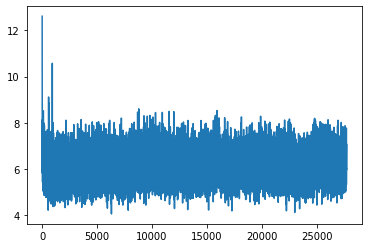

In [33]:
# looking the loss plot
plt.plot(losses)

In [34]:
# saving the models for future use

encoder_path = "encoder.pth"
torch.save(encoder, encoder_path)

decoder_path = "decoder.pth"
torch.save(decoder, decoder_path)

In [35]:
# # # load the models
# encoder = torch.load('../input/nlpasgn/encoder.pth')
# decoder = torch.load('../input/nlpasgn/dencoder.pth')

### Making Predictions on the test set

In [36]:
# Prediction function

def make_predictions(test_sentence):
    # Tokenizing, Encoding, transforming to Tensor
    test_sentence = torch.tensor(encoding_padding(en_word2idx, test_sentence, seq_length)).unsqueeze(dim=0)
    
    encoder_hidden = torch.zeros(1, 1, hidden_size) # initial input to encoder
    encoder_hidden = encoder_hidden.to(device) # taking to the tensor

    input_tensor = test_sentence.to(device) # taking to the tensor

    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()

    result = []

    encoder_outputs = torch.zeros(seq_length, encoder.hidden_size, device=device)


    with torch.set_grad_enabled(False): # turning of the gradients
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden) # passing the sentence through encoder

        dec_result = torch.zeros(target_length, 1, len(ko_index2word)).to(device)

        decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device) # sending the SOS to decoder
        decoder_hidden = encoder_hidden
        for di in range(1, target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            best = decoder_output.argmax(1)
            #print(best.to('cpu').item())
            result.append(ko_index2word[best.to('cpu').item()])
            if best.item() == EOS: # break when we reach EOS
                break

            decoder_input = best.unsqueeze(dim=0) 
            dec_result[di] = decoder_output
    #return " ".join(result[:-1]) # removing EOS from result
    return result[:-1] # removing EOS from result

In [37]:
for i in range(5):
    print('Sentence Number in test set: ----------', i, '---------------\n')
    print('Actual English Sentence : '," ".join(df_eng_test[i]))
    print('Translated Predictions:' , make_predictions(df_eng_test[i]))
    print('Actual Sentence:' , df_ko_test[i])
    print('\n')

Sentence Number in test set: ---------- 0 ---------------

Actual English Sentence :  allison hunt my three minutes hasnt started yet has it
Translated Predictions: ['웃음', '비무장지대', '기독교']
Actual Sentence: ['아직', '3분', '시작된', '건', '아니죠', '그렇죠']


Sentence Number in test set: ---------- 1 ---------------

Actual English Sentence :  chris anderson no you cant start the three minutes
Translated Predictions: ['홍콩', '유대인들뿐만', '<PAD>', '130']
Actual Sentence: ['크리스', '앤더슨네', '맘대로', '시작하실', '수', '없습니다']


Sentence Number in test set: ---------- 2 ---------------

Actual English Sentence :  reset the three minutes thats just not fair
Translated Predictions: ['그리고', '제']
Actual Sentence: ['3분', '다시', '설정해주세요', '이건', '반칙입니다']


Sentence Number in test set: ---------- 3 ---------------

Actual English Sentence :  ah oh my god its harsh up here
Translated Predictions: ['그리고', '제']
Actual Sentence: ['앨리슨', '헌트', '어머나', '여기', '참', '냉정하네요']


Sentence Number in test set: ---------- 4 ---------------



In [38]:
from torchtext.data.metrics import bleu_score

# https://pytorch.org/text/stable/data_metrics.html

def bleu(src_data, tar_data):
    targets = []
    outputs = []
    for i in zip(src_data , tar_data):
        src = i[0]
        trg = i[1]
        prediction = make_predictions(src)
        targets.append([str(ko_word2idx[word]) for word in trg])
        outputs.append([str(ko_word2idx[word]) for word in prediction])
    return bleu_score(outputs, targets,max_n=1,weights=[1])

In [39]:
# Bleu score on test dataset
score = bleu(df_eng_test,df_ko_test)
print(f"Bleu score {score*100:.2f}")

Bleu score 11.16
